# **NATURAL LANGUAGE PROCESSING**

- Project Name: CAPSTONE PROJECT - NLP
- Project Objective: Design a Machine Translation model that can be used to translate sentences from German language to English language or vice-versa.
- Project Group: March 22 Capstone Grp 9
- Project Team: Ajay KV, Bijay, Kiran, Rajesh Kumar,Srideepa,Sushma


In [1]:
pip install keras_preprocessing

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 KB 1.2 MB/s eta 0:00:00


In [2]:
import string
import re
import os
import pandas as pd
import numpy as np
from wordcloud import WordCloud
from numpy import array, argmax, random, take
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Bidirectional,SimpleRNN,BatchNormalization,RepeatVector,Dropout
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras_preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras.utils import plot_model
from keras import optimizers
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib as mpl
import matplotlib.pyplot as plt
import pickle
from keras.layers import TimeDistributed

In [ ]:
#pip list | grep tensorflow

tensorflow                    2.11.0
tensorflow-datasets           4.8.2
tensorflow-estimator          2.11.0
tensorflow-gcs-config         2.11.0
tensorflow-hub                0.12.0
tensorflow-io-gcs-filesystem  0.31.0
tensorflow-metadata           1.12.0
tensorflow-probability        0.19.0


In [3]:
# Ignore all unnecessary Warning 
import warnings
warnings.filterwarnings('ignore')

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Corpus Path**

In [5]:
eu_de_file_path = '/content/drive/My Drive/Colab Notebooks/Capstone project NLP/europarl-v7_de_en.txt'
eu_en_file_path = '/content/drive/My Drive/Colab Notebooks/Capstone project NLP/europarl-v7_en_de.txt'
co_de_file_path = '/content/drive/My Drive/Colab Notebooks/Capstone project NLP/commoncrawl_de_en.txt'
co_en_file_path = '/content/drive/My Drive/Colab Notebooks/Capstone project NLP/commoncrawl_en_de.txt'
news_de_file_path = '/content/drive/My Drive/Colab Notebooks/Capstone project NLP/news-commentary-v9_de_en.txt'
news_en_file_path = '/content/drive/My Drive/Colab Notebooks/Capstone project NLP/news-commentary-v9_en_de.txt'
GLOVE_EMBEDDING_FILE = '/content/drive/My Drive/Colab Notebooks/Capstone project NLP/glove.6B.200d.txt'
model_pickle = '/content/drive/My Drive/Colab Notebooks/Capstone project NLP/model.pkl'   #Save and load Pickel file name
train_pickle = '/content/drive/My Drive/Colab Notebooks/Capstone project NLP/train.pkl'   #Save and load train Pickel file name
test_pickle = '/content/drive/My Drive/Colab Notebooks/Capstone project NLP/test.pkl'   #Save and load test Pickel file name
tokenizer_pickle = '/content/drive/My Drive/Colab Notebooks/Capstone project NLP/token_de.pkl'   #Save and load test Pickel file name

**Constant Variable**

In [6]:
eu_de_title = 'German Sentence Length for Europarl dataset'
eu_en_title = 'English Sentence Length for Europarl dataset'
cocrawl_de_title = 'German Sentence Length for commoncrawl dataset'
cocrawl_en_title = 'English Sentence Length for commoncrawl dataset'
Newscommentary_de_title = 'German Sentence Length for news-commentary dataset'
Newscommentary_en_title = 'English Sentence Length for news-commentary dataset'
de_title = 'German Sentence Length'
en_title = 'English Sentence Length'
Max_de_en_len = 5000
LSTM_model = 1
RNN_model = 0
EPOCH_size_simple_model = 10
BATCH_size_simple_model = 256
EPOCH_size = 10
BATCH_size = 64
UNIT_size = 256
MAX_NUM_Words = 20000
EMBEDDING_DIMENSION = 200

In [7]:
# function name: load_text_file
# input: filepath,max_len
# description: This method open a given file, check number of lines in this file and get sentences in one list and keep blank line index to a list and return arr,blk_arr list

def load_text_file(filepath,max_len):
    # open the file
    fp = open(filepath, mode='rt', encoding='utf-8')

    lines = fp.readlines()
    
    print('Total number of sentences in this file:',len(lines))   
    count = 0
    i = 0
    arr = []
    blk_arr = []

    for line in lines:
      sent = line.strip('\n')
      if(sent == ''):
        i = i+1
        blk_arr.append(count)
      
      arr.append(sent)
     
      count = count+1
      if(count >= max_len):
        break

    print('Total no of blank line:',i)
    fp.close()

    return arr,blk_arr

In [8]:
# function name: del_sentences_get_list
# input: de_blnk_list,en_blnk_list,de_arr,en_arr
# description: This method take two blank index list and make single list with desending order and removes those index 
#              from provided German and English list and return de_arr and en_arr

def del_sentences_get_list(de_blnk_list,en_blnk_list,de_arr,en_arr):

  de_en_blnk_list = de_blnk_list + en_blnk_list
  print('Total blank lines in the dataset:',len(de_en_blnk_list))

  de_en_blnk_list = [*set(de_en_blnk_list)]     #remove duplicate rows.
  print('After removing duplicate entry total length of list:',len(de_en_blnk_list))

  de_en_blnk_list.sort(reverse=True)           # Arrange list in descending order so that we remove rows from bottom

  for index in de_en_blnk_list:
    del de_arr[index]
  
  print('length of list after deleting blank line for German:',len(de_arr))

  for index in de_en_blnk_list:
    del en_arr[index]
  
  print('length of list after deleting blank line for English:',len(en_arr))

  return de_arr,en_arr

In [9]:
# function name: cleanup_date
# input: de_arr,en_arr
# description: This method cleanup the lists and return lists.

def cleanup_date(de_arr,en_arr):
  # Remove punctuation
  de_arr = [s.translate(str.maketrans('', '', string.punctuation)) for s in de_arr]
  en_arr = [s.translate(str.maketrans('', '', string.punctuation)) for s in en_arr]

  # convert to lowercase
  for i in range(len(en_arr)):
    de_arr[i] = de_arr[i].lower()    
    en_arr[i] = en_arr[i].lower()
  
  return de_arr,en_arr

In [10]:
# function name: tokenization
# input: arr_list
# description: This method tokanize the give sentences list and return tokenize vector.
# function to build a tokenizer
def tokenization(arr_list):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(arr_list)
    return tokenizer

In [11]:
# function name: padding_sequence
# input: tokenizer,max_len,arr_list
# description: This method to do padding of all vectors with limiting to max_len 

def padding_sequence(tokenizer,max_len,arr_list):
  
  # integer encode sequences
  list_sequences = tokenizer.texts_to_sequences(arr_list)

  # pad sequences with 0 values
  list_sequences = pad_sequences(list_sequences, maxlen=max_len,dtype='int32', padding='post')
  return list_sequences

In [12]:
# function name: build_simple_model
# input: in_vocab, out_vocab, in_timesteps, out_timesteps, units,lstm_flag,train_x,train_y,epochs,batch_size
# description: This method create a simple RNN and LSTM model depending on lstm_flag with activation as softmax. This model has just a single LSTM or RNN layer.

def build_simple_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units,lstm_flag,train_x,train_y,epochs,batch_size,test_X, test_Y):
  
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps))

    if(lstm_flag):
      model.add(LSTM(units))                #Simple LSTM model
    else:
      model.add(SimpleRNN(units))           # Simple RNN model

    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(units, return_sequences=True))
    model.add(TimeDistributed(Dense(out_vocab, activation='softmax')))

    rms = optimizers.RMSprop(lr=0.001)
    model.compile(optimizer=rms, loss='sparse_categorical_crossentropy', metrics=['acc'])

    #model_history = model.fit(train_x,train_y,epochs=epochs, batch_size=batch_size,validation_split = 0.2,verbose=1)

    filename = 'model.h5'
    checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    model_history = model.fit(train_x, train_y, epochs=10, batch_size=64, validation_data=(test_X, test_Y),verbose=2)

    return model,model_history

In [ ]:
# function name: plot_word_cloud
# input: arr
# description: This method plot word cloud.

def plot_word_cloud(arr):
  wc = WordCloud(width=1200,height=600).generate(' '.join(arr))
  plt.figure( figsize=(20,10) )
  plt.imshow(wc)
  plt.axis('off')
  plt.show()

In [ ]:
# function name: plot_sent_len
# input: de_arr,en_arr
# description: This method plot histogram of sentences length vs many sentences

def plot_sent_len(de_arr,en_arr,de_title,en_title):
  
  en_l = []
  de_l = []

  # populate the lists with sentence lengths
  for i in de_arr:
    en_l.append(len(i.split()))

  for i in en_arr:
    de_l.append(len(i.split()))
  
  # Plot sentence length vs Frequency graph for English dataset
  mpl.rc('text', color='blue')
  plt.figure( figsize=(12,6) )
  plt.title(en_title)
  plt.xlabel('Length')
  plt.ylabel('Frequency')
  plt.hist(en_l,bins = 60)
  plt.show()

  # Plot sentence length vs Frequency graph for German dataset
  plt.figure( figsize=(12,6) )
  plt.title(de_title)
  plt.xlabel('Length')
  plt.ylabel('Frequency')
  plt.hist(de_l,bins = 60)
  plt.show()

  return en_l,de_l

In [ ]:
# function name: plotWordFrequency
# input: arr,title
# description: This method plot diagram for Word Frequency.

def plotWordFrequency(arr,title):
    freq = pd.Series(' '.join(arr).split()).value_counts()[:20]
    freq = freq[::-1]
    freq.plot(kind='barh', figsize=(12, 6))
    plt.title(title)
    plt.xlabel('Frequency')


In [ ]:
# function name: plot_model_accuracy
# input: model_history,title
# description: This method plot accuracy for model.

def plot_model_accuracy(model_history,title):
  plt.plot(model_history.history['acc'], label='acc')
  plt.plot(model_history.history['val_acc'], label='val_acc')
  plt.title(title)
  plt.legend()

In [ ]:
# function name: plot_model_loss
# input: model_history,title
# description: This method plot loss for model.

def plot_model_loss(model_history,title):
  plt.plot(model_history.history['loss'], label='loss')
  plt.plot(model_history.history['val_loss'], label='val_loss')
  plt.title(title)
  plt.legend()

In [13]:
# function name: split_and_reshape
# input: x,y,eng_tokenizer,deu_tokenizer,length
# description: This method split the dataset, do padding and make dataset ready for RNN and LSTM model.

def split_and_reshape(x,y,eng_tokenizer,deu_tokenizer,length):

  train_x, test_x,train_y,test_y = train_test_split(x,y, test_size=0.2, random_state = 12)

  train_pad_x = padding_sequence(eng_tokenizer,length,train_x)
  train_pad_y = padding_sequence(deu_tokenizer,length,train_y)
  test_pad_x = padding_sequence(eng_tokenizer,length,test_x)
  test_pad_y = padding_sequence(deu_tokenizer,length,test_y)

  print('Shape for dataset before reshaping for train_pad_x',train_pad_x.shape)
  print('Shape for dataset before reshaping for train_pad_y',train_pad_y.shape)

  # Converting 2D to 3D for RNN and LSTM model.
  train_3d_x = train_pad_x.reshape(train_pad_x.shape[0], train_pad_x.shape[1], 1)
  train_3d_y = train_pad_y.reshape(train_pad_y.shape[0], train_pad_y.shape[1], 1)
  test_3d_x = test_pad_x.reshape(test_pad_x.shape[0], test_pad_x.shape[1], 1)
  test_3d_y = test_pad_y.reshape(test_pad_y.shape[0], test_pad_y.shape[1], 1)

  print('Shape for dataset after reshaping for train_3d_x',train_3d_x.shape)
  print('Shape for dataset after reshaping for train_3d_y',train_3d_y.shape)
  
  return train_3d_x,train_3d_y,test_3d_x,test_3d_y,test_pad_x,test_pad_y,train_pad_x,train_pad_y

In [ ]:
# function name: get_glove_embedding
# input: glove_file_path,in_vocab
# description: This method do word2vec with the help of glove embedding for input vocabalary for glove.6B.200d data

def get_glove_embedding(glove_file_path,in_vocab):

  word2vec = {}
  with open(os.path.join(glove_file_path),encoding='utf8') as lines:
  
    for line in lines:
      values = line.split()
      word = values[0]
      vec = np.asarray(values[1:], dtype='float32')
      word2vec[word] = vec

  print('Number of words found in glove.6B.200d: ',len(word2vec))

  in_num_words = len(in_vocab) + 1
  #in_num_words = min(MAX_NUM_Words, len(in_vocab) + 1)
  print('Minimum number of words:',in_num_words)
  glove_embedding = np.zeros((in_num_words, EMBEDDING_DIMENSION))

  for word, i in in_vocab.items():
    if i < in_num_words:        
      embedding_vector = word2vec.get(word)    
      if embedding_vector is not None: 
        glove_embedding[i] = embedding_vector
  
  print('Shape of glove of embedding:',glove_embedding.shape)

  return glove_embedding,in_num_words



In [ ]:
# function name: build_rnn_lstm_model_with_glove
# input: in_num_words,out_num_words,glove_embedding,max_len_input,max_len_out,units,lstm_flag,train_x,train_y,epochs,batch_size
# description: This is a common method for RNN and LSTM model with glove embedding. It has one hidden layer WRT RNN or LSTM

def build_rnn_lstm_model_with_glove(in_num_words,out_num_words,glove_embedding,max_len_input,max_len_out,units,lstm_flag,train_x,train_y,epochs,batch_size):

  model = Sequential()
  model.add(Embedding(in_num_words,output_dim = EMBEDDING_DIMENSION, weights=[glove_embedding],input_length=max_len_input,trainable = True))

  if(lstm_flag):
    model.add(LSTM(units))                #Simple LSTM model
  else:
    model.add(SimpleRNN(units))           # Simple RNN model

  model.add(RepeatVector(max_len_out))
  if(lstm_flag):
    model.add(LSTM(units, return_sequences=True))
  else:
    model.add(SimpleRNN(units,return_sequences=True))

  model.add(Dense(out_num_words, activation='softmax'))

  rms = optimizers.RMSprop(lr=0.001)
  model.compile(optimizer=rms, loss='sparse_categorical_crossentropy', metrics=['acc'])

  model_history = model.fit(train_x,train_y,epochs=epochs, batch_size=batch_size,validation_split = 0.2,verbose=1)

  return model,model_history


In [ ]:
# function name: build_rnn_bi_lstm_model_with_glove
# input: in_num_words,out_num_words,glove_embedding,max_len_input,max_len_out,units,lstm_flag,train_x,train_y,epochs,batch_size
# description: This is a common method for Bi-directional RNN and LSTM model with glove embedding. It has two hidden layer WRT RNN or LSTM

def build_rnn_bi_lstm_model_with_glove(in_num_words,out_num_words,glove_embedding,max_len_input,max_len_out,units,lstm_flag,train_x,train_y,epochs,batch_size):

  model = Sequential()
  model.add(Embedding(in_num_words,output_dim = EMBEDDING_DIMENSION, weights=[glove_embedding],input_length=max_len_input,trainable = True))

  if(lstm_flag):
    model.add(Bidirectional(LSTM(units)))                #Simple LSTM model
  else:
    model.add(Bidirectional(SimpleRNN(units)))           # Simple RNN model

  model.add(RepeatVector(max_len_out))
  if(lstm_flag):
    model.add(Bidirectional(LSTM(units, return_sequences=True)))
    model.add(Bidirectional(LSTM(units, return_sequences=True)))
  else:
    model.add(Bidirectional(SimpleRNN(units, return_sequences=True)))
    model.add(Bidirectional(SimpleRNN(units, return_sequences=True)))

  model.add(Dense(out_num_words, activation='softmax'))

  rms = optimizers.RMSprop(lr=0.001)
  model.compile(optimizer=rms, loss='sparse_categorical_crossentropy', metrics=['acc'])

  model_history = model.fit(train_x,train_y,epochs=epochs,batch_size=batch_size,validation_split = 0.2,verbose=1)

  return model,model_history


In [14]:
def predict_sequence(model, tokenizer, source):
	#prediction = model.predict(source, verbose=0)[0]
	prediction = model.predict(source, verbose=0)[0]
	print('prediction:',prediction)
	ints = [argmax(vector) for vector in prediction]
	#ints = np.argmax(prediction)
	print('ints:',ints)
	target = list()
	count = 0
	for i in ints:
		word = word_for_id(i, tokenizer)
		count = count+1
		#if(count>12):
		#	break
		if word is None:
			break
		target.append(word)
	return ' '.join(target)

In [15]:
def word_for_id(ints, tokenizer):
  for word, index in tokenizer.word_index.items():
    #print('ints:',ints,'index:',index)
    if(index == ints):
      return word
  #print('return NONE')
  return None

In [16]:
def evaluate_model(model, tokenizer, sources):
	actual, predicted = list(), list()
	for i, source in enumerate(sources):
		# translate encoded source text
		source = source.reshape((1, source.shape[0]))
		translation = predict_sequence(model, tokenizer, source)
		#raw_target, raw_src = raw_dataset[i]
		if i < 10:
			print('predicted=[%s]' % (translation))
		#actual.append([raw_target.split()])
		predicted.append(translation.split())

In [17]:
def get_word(num, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == num:
            return word
    return None

# Milestone 1

# **Step 1**

In [17]:
eu_de_arr,eu_de_blnk_list = load_text_file(eu_de_file_path,Max_de_en_len)

Total number of sentences in this file: 1920209
Total no of blank line: 11


In [18]:
eu_en_arr,eu_en_blnk_list = load_text_file(eu_en_file_path,Max_de_en_len)

Total number of sentences in this file: 1920209
Total no of blank line: 17


In [19]:
co_de_arr,co_de_blnk_list = load_text_file(co_de_file_path,Max_de_en_len)

Total number of sentences in this file: 2399123
Total no of blank line: 0


In [20]:
co_en_arr,co_en_blnk_list = load_text_file(co_en_file_path,Max_de_en_len)

Total number of sentences in this file: 2399123
Total no of blank line: 0


In [21]:
news_de_arr,news_de_blnk_list = load_text_file(news_de_file_path,Max_de_en_len)

Total number of sentences in this file: 201854
Total no of blank line: 2


In [22]:
news_en_arr,news_en_blnk_list = load_text_file(news_en_file_path,Max_de_en_len)

Total number of sentences in this file: 201995
Total no of blank line: 5


- Total 1920209 sentences in europarl text file.
- Total 2399123 sentences in commoncrawl text file.
- Total 201854 and 201995 sentences for German and English in news commentary text file.
- **With this many sentences system is getting crashed.So we need to reduce number of sentences. Currently took 5000 sentences from each dataset so total sentences are 15K (3x5000 sentences) for German and 15K for English.** 

In [23]:
eu_de_arr,eu_en_arr = del_sentences_get_list(eu_de_blnk_list,eu_en_blnk_list,eu_de_arr,eu_en_arr)

Total blank lines in the dataset: 28
After removing duplicate entry total length of list: 28
length of list after deleting blank line for German: 4972
length of list after deleting blank line for English: 4972


In [24]:
co_de_arr,co_en_arr = del_sentences_get_list(co_de_blnk_list,co_en_blnk_list,co_de_arr,co_en_arr)

Total blank lines in the dataset: 0
After removing duplicate entry total length of list: 0
length of list after deleting blank line for German: 5000
length of list after deleting blank line for English: 5000


In [25]:
news_de_arr,news_en_arr = del_sentences_get_list(news_de_blnk_list,news_en_blnk_list,news_de_arr,news_en_arr)

Total blank lines in the dataset: 7
After removing duplicate entry total length of list: 7
length of list after deleting blank line for German: 4993
length of list after deleting blank line for English: 4993


## **EDA**

# **Sentence length analysis before merging the dataset**

Helps in understanding the length of the sentence in both languages for given  datasets.

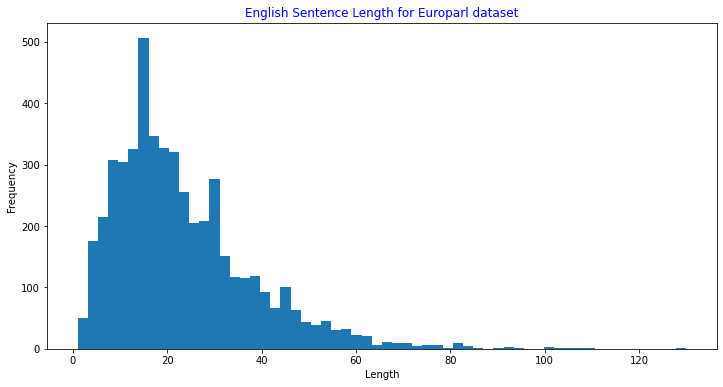

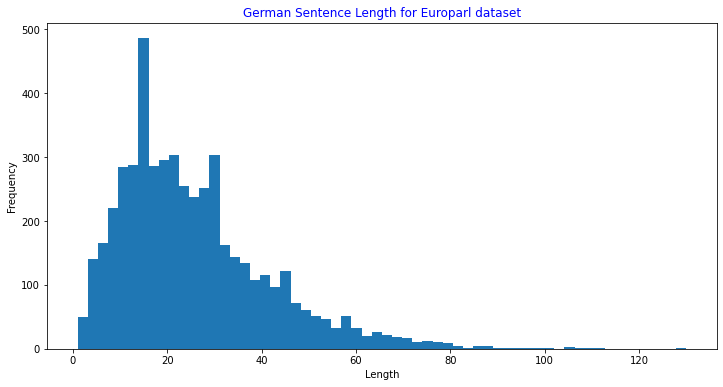

In [ ]:
en,de = plot_sent_len(eu_de_arr,eu_en_arr,eu_de_title,eu_en_title)

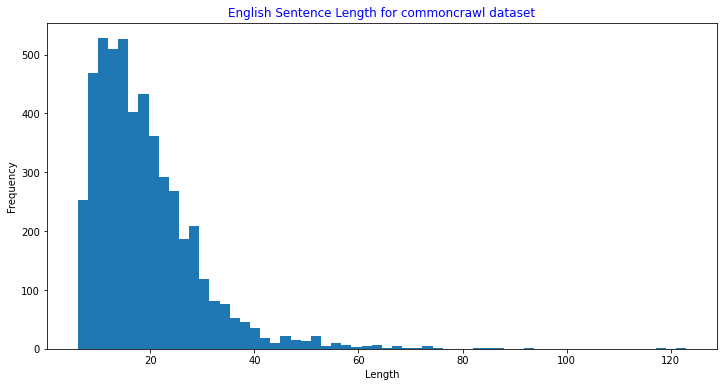

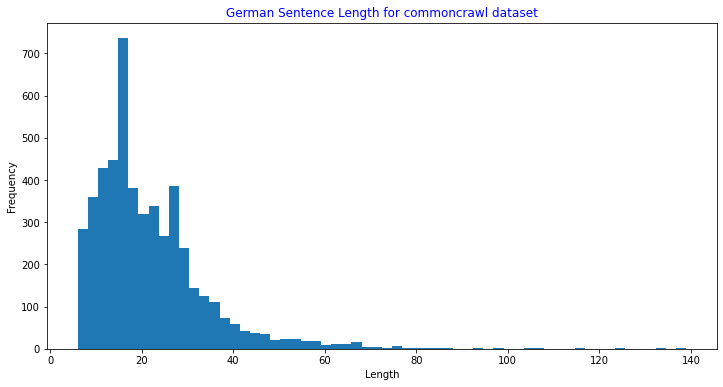

In [ ]:
en,de = plot_sent_len(co_de_arr,co_en_arr,cocrawl_de_title,cocrawl_en_title)

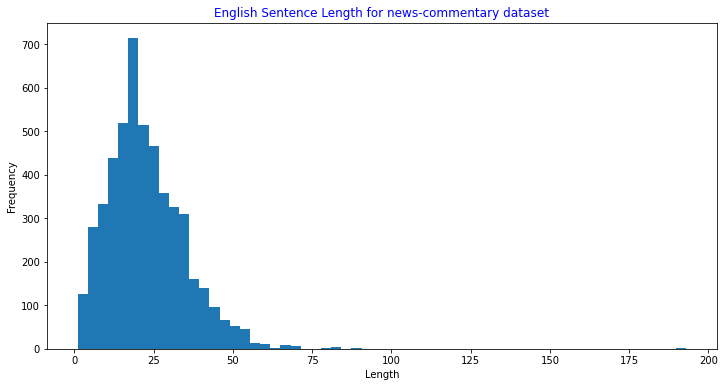

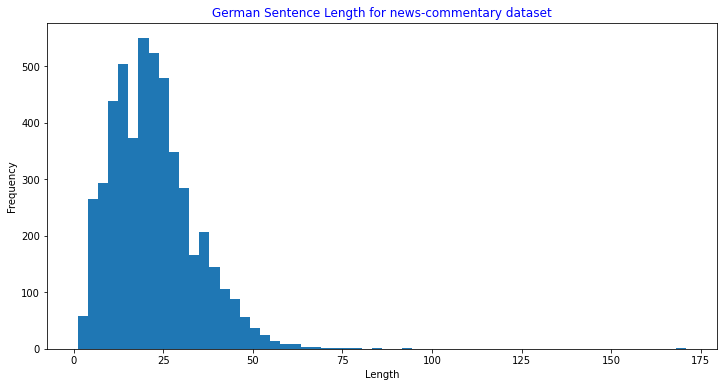

In [ ]:
en,de = plot_sent_len(news_de_arr,news_en_arr,Newscommentary_de_title,Newscommentary_en_title)

**Merging all three dataset**

In [26]:
de_arr = eu_de_arr + co_de_arr + news_de_arr
en_arr = eu_en_arr + co_en_arr + news_en_arr

In [ ]:
print('Total number of German sentences:',len(de_arr))
print('Total number of English sentences:',len(en_arr))

Total number of German sentences: 14965
Total number of English sentences: 14965


# **Step 2**

In [27]:
de_arr,en_arr = cleanup_date(de_arr,en_arr)

In [ ]:
de_arr[:10]

['wiederaufnahme der sitzungsperiode',
 'ich erkläre die am freitag dem 17 dezember unterbrochene sitzungsperiode des europäischen parlaments für wiederaufgenommen wünsche ihnen nochmals alles gute zum jahreswechsel und hoffe daß sie schöne ferien hatten',
 'wie sie feststellen konnten ist der gefürchtete milleniumbug  nicht eingetreten doch sind bürger einiger unserer mitgliedstaaten opfer von schrecklichen naturkatastrophen geworden',
 'im parlament besteht der wunsch nach einer aussprache im verlauf dieser sitzungsperiode in den nächsten tagen',
 'heute möchte ich sie bitten  das ist auch der wunsch einiger kolleginnen und kollegen  allen opfern der stürme insbesondere in den verschiedenen ländern der europäischen union in einer schweigeminute zu gedenken',
 'ich bitte sie sich zu einer schweigeminute zu erheben',
 'das parlament erhebt sich zu einer schweigeminute',
 'frau präsidentin zur geschäftsordnung',
 'wie sie sicher aus der presse und dem fernsehen wissen gab es in sri lank

In [ ]:
en_arr[:10]

['resumption of the session',
 'i declare resumed the session of the european parliament adjourned on friday 17 december 1999 and i would like once again to wish you a happy new year in the hope that you enjoyed a pleasant festive period',
 'although as you will have seen the dreaded millennium bug failed to materialise still the people in a number of countries suffered a series of natural disasters that truly were dreadful',
 'you have requested a debate on this subject in the course of the next few days during this partsession',
 'in the meantime i should like to observe a minute s silence as a number of members have requested on behalf of all the victims concerned particularly those of the terrible storms in the various countries of the european union',
 'please rise then for this minute s silence',
 'the house rose and observed a minute s silence',
 'madam president on a point of order',
 'you will be aware from the press and television that there have been a number of bomb explosi

## **Sentence length analysis after merging the dataset**

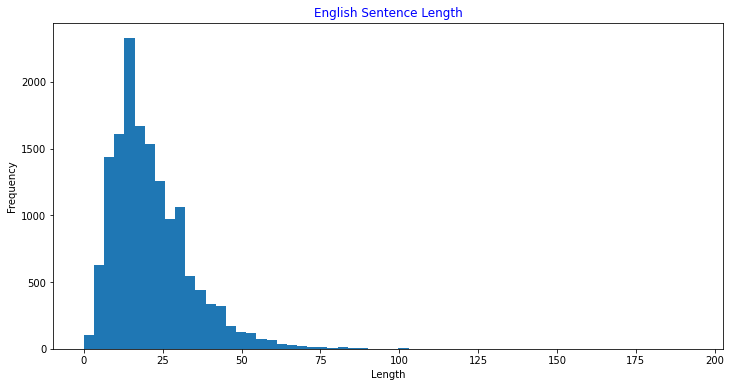

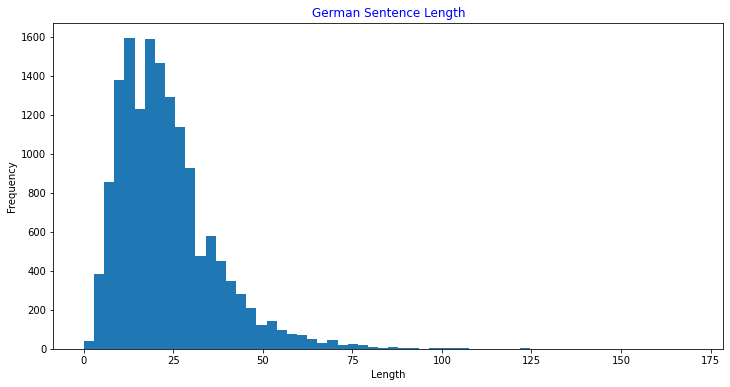

In [ ]:
en_l,de_l = plot_sent_len(de_arr,en_arr,de_title,en_title)

## **Word frequency analysis**

Another way to see which words are the most common in both English and German text

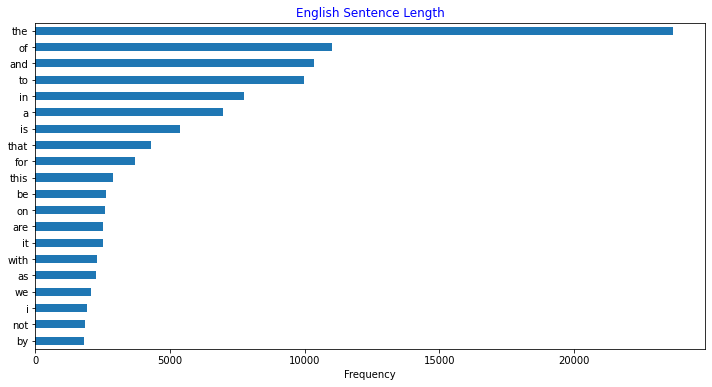

In [ ]:
plotWordFrequency(en_arr,en_title)

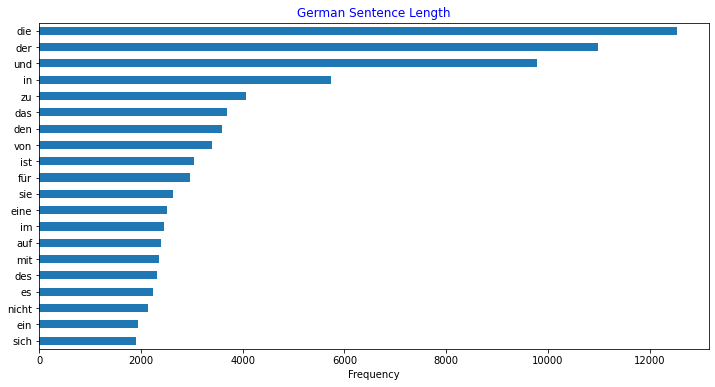

In [ ]:
plotWordFrequency(de_arr,de_title)

In [ ]:
print('Maximum length of english sentence:',max(en_l))

Maximum length of english sentence: 193


In [ ]:
print('Maximum length of de sentence:',max(de_l))

Maximum length of de sentence: 170


As per plot we can see max length of string is near 120 but above some of sentences we can see 193 length for english and 170 for dutch. So for padding we will keep 50 for each dataset.

# **Wordcloud analysis**

Wordcloud analysis is done to get the idea of the most frequent words in the dataset. This is a good way to get the idea of the language and its most frequently used words.

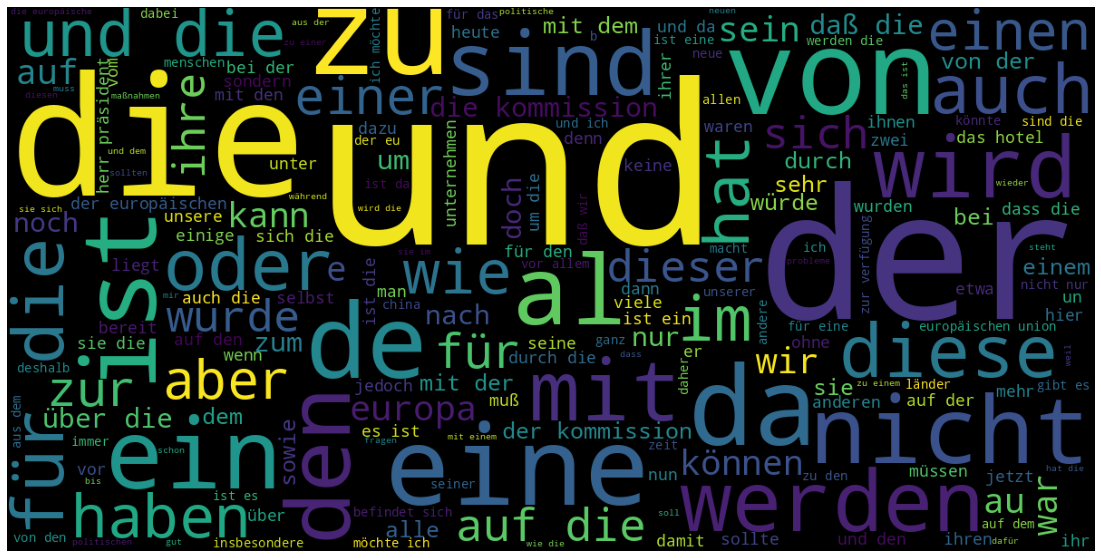

In [ ]:
plot_word_cloud(de_arr)

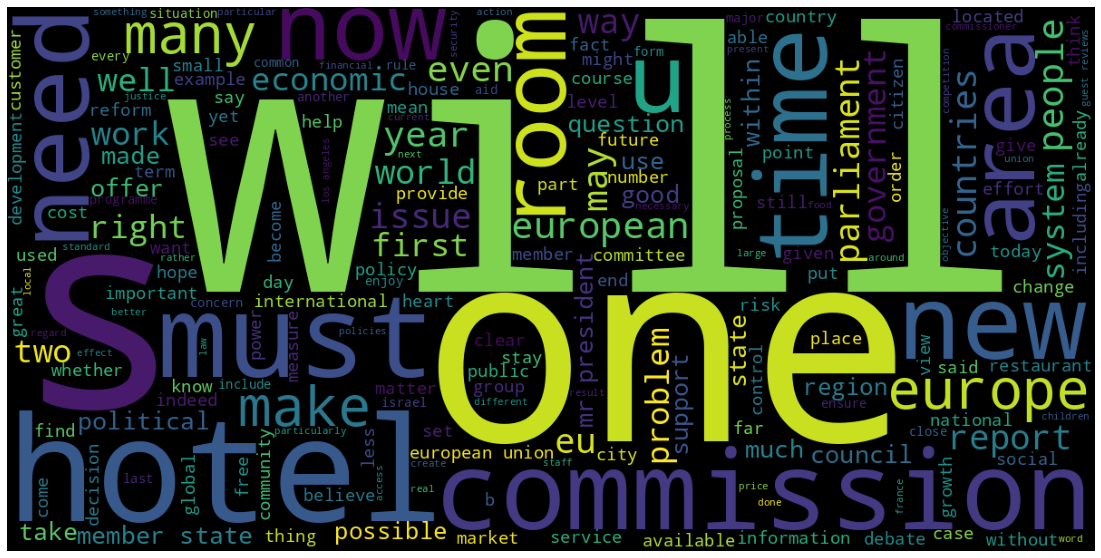

In [ ]:
plot_word_cloud(en_arr)

# **Step 3**

In [28]:
# prepare english tokenizer
eng_tokenizer = tokenization(en_arr)
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_vocab = eng_tokenizer.word_index
eng_length = 50

print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 23221


In [29]:
# prepare Deutch tokenizer
deu_tokenizer = tokenization(de_arr)
deu_vocab_size = len(deu_tokenizer.word_index) + 1
deu_vocab = deu_tokenizer.word_index
deu_length = 50
print('Deutch Vocabulary Size: %d' % deu_vocab_size)

Deutch Vocabulary Size: 37068


# **Step 4**

**Input as English and translate to German for RNN model**

In [31]:
train_en_in,train_de_out,test_en_in,test_de_out,test_en_x,test_de_y,train_en_x,train_de_y = split_and_reshape(en_arr,
                                             de_arr,
                                             eng_tokenizer,
                                             deu_tokenizer,
                                             eng_length)

Shape for dataset before reshaping for train_pad_x (11972, 50)
Shape for dataset before reshaping for train_pad_y (11972, 50)
Shape for dataset after reshaping for train_3d_x (11972, 50, 1)
Shape for dataset after reshaping for train_3d_y (11972, 50, 1)


In [44]:
train_en_x.shape

(11972, 50)

In [45]:
train_de_y.shape

(11972, 50)

In [ ]:
rnn_model_en,rnn_history_en = build_simple_model(eng_vocab_size, 
                                                 deu_vocab_size, 
                                                 eng_length, 
                                                 deu_length, 
                                                 UNIT_size,
                                                 RNN_model,
                                                 train_en_in,
                                                 train_de_out,
                                                 EPOCH_size_simple_model,
                                                 BATCH_size_simple_model)

Epoch 1/10
38/38 [==============================] - 23s 480ms/step - loss: 5.1935 - acc: 0.5253 - val_loss: 4.0214 - val_acc: 0.5762
Epoch 2/10
38/38 [==============================] - 18s 478ms/step - loss: 3.9988 - acc: 0.5789 - val_loss: 4.0965 - val_acc: 0.5754
Epoch 3/10
38/38 [==============================] - 18s 488ms/step - loss: 4.1160 - acc: 0.5763 - val_loss: 4.0052 - val_acc: 0.5772
Epoch 4/10
38/38 [==============================] - 18s 488ms/step - loss: 3.9401 - acc: 0.5807 - val_loss: 4.1327 - val_acc: 0.5765
Epoch 5/10
38/38 [==============================] - 18s 474ms/step - loss: 3.9623 - acc: 0.5800 - val_loss: 4.0469 - val_acc: 0.5773
Epoch 6/10
38/38 [==============================] - 18s 474ms/step - loss: 3.9126 - acc: 0.5808 - val_loss: 4.0613 - val_acc: 0.5773
Epoch 7/10
38/38 [==============================] - 18s 483ms/step - loss: 3.9227 - acc: 0.5806 - val_loss: 4.0599 - val_acc: 0.5773
Epoch 8/10
38/38 [==============================] - 18s 488ms/step - 

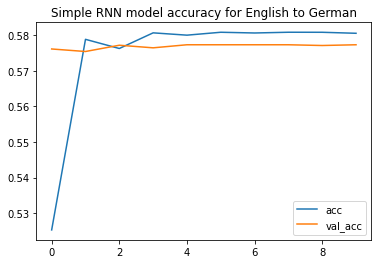

In [ ]:
plot_model_accuracy(rnn_history_en,'Simple RNN model accuracy for English to German')

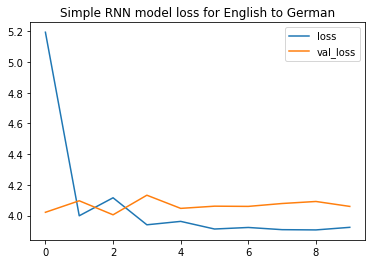

In [ ]:
plot_model_loss(rnn_history_en,'Simple RNN model loss for English to German')

**Input as English and translate to German for LSTM model**

AttributeError: ignored

In [57]:
lstm_model_en,lstm_history_en = build_simple_model(eng_vocab_size, 
                                                   deu_vocab_size, 
                                                   eng_length, 
                                                   deu_length, 
                                                   UNIT_size,
                                                   LSTM_model,
                                                   train_en_in,
                                                   train_de_out,
                                                   EPOCH_size_simple_model,
                                                   BATCH_size_simple_model,test_en_x,test_de_y)

Epoch 1/10
188/188 - 45s - loss: 4.0134 - acc: 0.5787 - val_loss: 4.0181 - val_acc: 0.5770 - 45s/epoch - 237ms/step
Epoch 2/10
188/188 - 40s - loss: 3.6612 - acc: 0.5845 - val_loss: 3.7420 - val_acc: 0.5797 - 40s/epoch - 212ms/step
Epoch 3/10
188/188 - 40s - loss: 3.4734 - acc: 0.5867 - val_loss: 3.6532 - val_acc: 0.5764 - 40s/epoch - 212ms/step
Epoch 4/10
188/188 - 40s - loss: 3.4129 - acc: 0.5874 - val_loss: 3.7789 - val_acc: 0.5714 - 40s/epoch - 212ms/step
Epoch 5/10
188/188 - 40s - loss: 3.3859 - acc: 0.5880 - val_loss: 3.4821 - val_acc: 0.5831 - 40s/epoch - 215ms/step
Epoch 6/10
188/188 - 40s - loss: 3.3581 - acc: 0.5885 - val_loss: 3.5132 - val_acc: 0.5832 - 40s/epoch - 215ms/step
Epoch 7/10
188/188 - 40s - loss: 3.3309 - acc: 0.5899 - val_loss: 3.5053 - val_acc: 0.5842 - 40s/epoch - 212ms/step
Epoch 8/10
188/188 - 40s - loss: 3.2993 - acc: 0.5913 - val_loss: 3.6211 - val_acc: 0.5693 - 40s/epoch - 212ms/step
Epoch 9/10
188/188 - 40s - loss: 3.2710 - acc: 0.5922 - val_loss: 3.4461

In [33]:
train_en_x1 = train_en_x[:10]

In [34]:
train_en_x1

array([[  867,     3,    21,   102,    14,  2118,     4,   220,    20,
           58,  4056,     8,     1,   362,    12,  5368,   676,   360,
          348,   840,    55,    25,     1,   215,     2,   105,    76,
            3,    62,    19,   840,     5,     6, 12705,     3,  2654,
          120,  2570,   105,    76,     5,   914,     2, 12706,   238,
           78,    16,  2950,    31,  9319],
       [   15,  1016,  1376,    10,  1138,   951,   302, 11788,  1137,
         2662,   333,    77,   422,     4,  2089,     4,    36,   258,
            8,  2993,  4915,  1950,     3,    32,     5,    36,   409,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0],
       [    7,   135, 11493,   157,   358,    14,  7364,    10,   106,
         3168,    49,  2133,  3013,     9,  1037,  1722,    49,    14,
           34,   924, 10888,    85,  7621,  3013,  2575,    

In [ ]:
test_en_x1 = test_en_x[:10]

In [58]:
evaluate_model(lstm_model_en, deu_tokenizer, train_en_x1)

prediction: [[7.6718656e-03 4.1636948e-02 2.5153151e-02 ... 3.0534254e-06
  3.0239135e-06 3.0324529e-06]
 [4.0505957e-03 9.9013895e-03 1.2564978e-02 ... 3.9398392e-06
  3.8783919e-06 3.9551387e-06]
 [7.3565561e-03 3.1314895e-02 2.6882492e-02 ... 1.8357373e-06
  1.8360122e-06 1.8339051e-06]
 ...
 [5.0710231e-01 8.5036466e-03 1.6072970e-02 ... 4.7519961e-07
  4.7925380e-07 4.7704543e-07]
 [5.1894099e-01 8.4061334e-03 1.5959829e-02 ... 4.5233568e-07
  4.5597341e-07 4.5389305e-07]
 [5.3059351e-01 8.3059166e-03 1.5839236e-02 ... 4.3068741e-07
  4.3396105e-07 4.3197414e-07]]
ints: [1, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
predicted=[die der die der die der der der der der der]
prediction: [[3.0297956e-03 4.0979385e-02 1.5847098e-02 ... 3.9688516e-06
  3.9736765e-06 3.9752422e-06]
 [2.5223482e-03 2.6364321e-02 2.4597872e-02 ... 2.4431004e-06
  2.3999949e-06 2.3915093e-06]
 [2.1380684e-

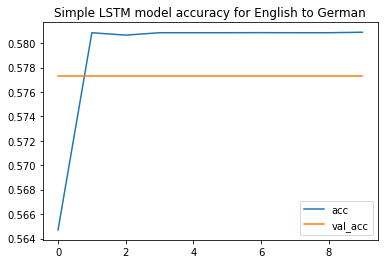

In [ ]:
plot_model_accuracy(lstm_history_en,'Simple LSTM model accuracy for English to German')

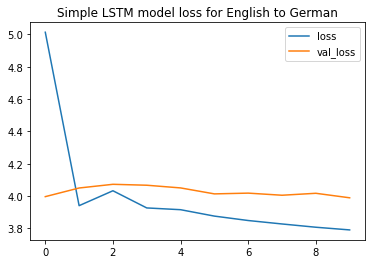

In [ ]:
plot_model_loss(lstm_history_en,'Simple LSTM model loss for English to German')

**Input as German and translate to English for RNN model**

In [30]:
train_de_in,train_en_out,test_de_in,test_en_out,test_de_x,test_en_y,train_de_x,train_en_y = split_and_reshape(de_arr,
                                             en_arr,
                                             deu_tokenizer,
                                             eng_tokenizer,
                                             eng_length)

Shape for dataset before reshaping for train_pad_x (11972, 50)
Shape for dataset before reshaping for train_pad_y (11972, 50)
Shape for dataset after reshaping for train_3d_x (11972, 50, 1)
Shape for dataset after reshaping for train_3d_y (11972, 50, 1)


In [ ]:
rnn_model_de,rnn_history_de = build_simple_model(deu_vocab_size, 
                                                 eng_vocab_size, 
                                                 deu_length, 
                                                 eng_length, 
                                                 UNIT_size,
                                                 RNN_model,
                                                 train_de_in,
                                                 train_en_out,
                                                 EPOCH_size_simple_model,
                                                 BATCH_size_simple_model)

Epoch 1/10
38/38 [==============================] - 15s 346ms/step - loss: 5.2700 - acc: 0.5214 - val_loss: 4.3833 - val_acc: 0.5331
Epoch 2/10
38/38 [==============================] - 13s 345ms/step - loss: 4.2233 - acc: 0.5432 - val_loss: 3.9664 - val_acc: 0.5492
Epoch 3/10
38/38 [==============================] - 13s 347ms/step - loss: 3.9020 - acc: 0.5527 - val_loss: 3.9829 - val_acc: 0.5495
Epoch 4/10
38/38 [==============================] - 13s 344ms/step - loss: 3.9830 - acc: 0.5497 - val_loss: 3.9392 - val_acc: 0.5495
Epoch 5/10
38/38 [==============================] - 13s 344ms/step - loss: 3.9010 - acc: 0.5527 - val_loss: 3.9410 - val_acc: 0.5495
Epoch 6/10
38/38 [==============================] - 12s 312ms/step - loss: 4.0934 - acc: 0.5447 - val_loss: 4.1553 - val_acc: 0.5472
Epoch 7/10
38/38 [==============================] - 12s 310ms/step - loss: 3.9656 - acc: 0.5522 - val_loss: 3.9392 - val_acc: 0.5494
Epoch 8/10
38/38 [==============================] - 14s 371ms/step - 

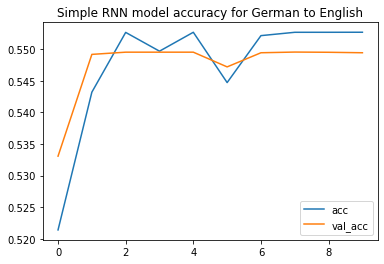

In [ ]:
plot_model_accuracy(rnn_history_de,'Simple RNN model accuracy for German to English')

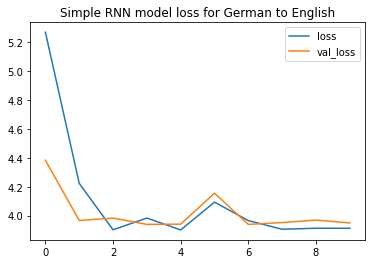

In [ ]:
plot_model_loss(rnn_history_de,'Simple RNN model loss for German to English')

In [31]:
lstm_model_de,lstm_history_de = build_simple_model(deu_vocab_size, 
                                                   eng_vocab_size, 
                                                   deu_length, 
                                                   eng_length, 
                                                   UNIT_size,
                                                   LSTM_model,
                                                   train_de_in,
                                                   train_en_out,
                                                   EPOCH_size_simple_model,
                                                   BATCH_size_simple_model,test_de_x,test_en_y)

Epoch 1/10
188/188 - 36s - loss: 3.9330 - acc: 0.5521 - val_loss: 3.7455 - val_acc: 0.5509 - 36s/epoch - 189ms/step
Epoch 2/10
188/188 - 28s - loss: 3.6261 - acc: 0.5601 - val_loss: 3.7284 - val_acc: 0.5532 - 28s/epoch - 150ms/step
Epoch 3/10
188/188 - 26s - loss: 3.4519 - acc: 0.5664 - val_loss: 3.5134 - val_acc: 0.5616 - 26s/epoch - 137ms/step
Epoch 4/10
188/188 - 28s - loss: 3.3954 - acc: 0.5681 - val_loss: 3.4680 - val_acc: 0.5618 - 28s/epoch - 149ms/step
Epoch 5/10
188/188 - 26s - loss: 3.3640 - acc: 0.5696 - val_loss: 3.4612 - val_acc: 0.5616 - 26s/epoch - 138ms/step
Epoch 6/10
188/188 - 28s - loss: 3.3256 - acc: 0.5709 - val_loss: 3.5115 - val_acc: 0.5616 - 28s/epoch - 149ms/step
Epoch 7/10
188/188 - 26s - loss: 3.2792 - acc: 0.5719 - val_loss: 3.4380 - val_acc: 0.5614 - 26s/epoch - 140ms/step
Epoch 8/10
188/188 - 26s - loss: 3.2380 - acc: 0.5730 - val_loss: 3.4889 - val_acc: 0.5626 - 26s/epoch - 137ms/step
Epoch 9/10
188/188 - 28s - loss: 3.2148 - acc: 0.5737 - val_loss: 3.4632

In [32]:
train_de_x1 = train_de_x[:10]

In [33]:
evaluate_model(lstm_model_de, eng_tokenizer, train_de_x1)

prediction: [[2.5280542e-03 6.9076613e-02 8.0144973e-03 ... 2.8576981e-06
  2.7729636e-06 2.7333151e-06]
 [1.6717446e-03 5.0685164e-02 1.1518369e-02 ... 2.3726993e-06
  2.3439052e-06 2.3100652e-06]
 [9.7853958e-04 5.7615362e-02 2.3649264e-02 ... 1.5012631e-06
  1.4923628e-06 1.5165625e-06]
 ...
 [1.4918427e-01 5.0570920e-02 3.1434007e-02 ... 6.5832904e-07
  6.4485437e-07 6.6523347e-07]
 [1.6496684e-01 5.0598051e-02 3.1809140e-02 ... 6.2860101e-07
  6.1434690e-07 6.3534810e-07]
 [1.8143426e-01 5.0550189e-02 3.2137234e-02 ... 5.9888976e-07
  5.8388667e-07 6.0508654e-07]]
ints: [18, 73, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
predicted=[i president the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the]
prediction: [[7.3492453e-03 9.9908367e-02 8.6205034e-03 ... 2.6710522e-06
  2.6478281e-06 2.6

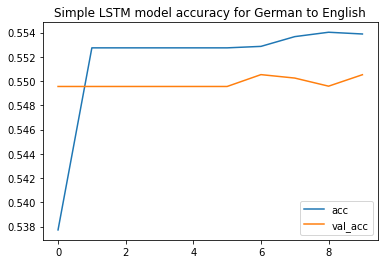

In [ ]:
plot_model_accuracy(lstm_history_de,'Simple LSTM model accuracy for German to English')

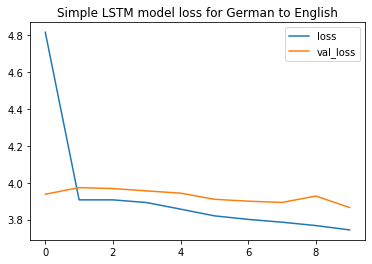

In [ ]:
plot_model_loss(lstm_history_de,'Simple LSTM model loss for German to English')

## **Milestone 2**

**Glove Embedding for English vocabulary**

In [ ]:
glove_embedding_en,in_num_words_en = get_glove_embedding(GLOVE_EMBEDDING_FILE,eng_vocab)

Number of words found in glove.6B.200d:  400000
Minimum number of words: 23221
Shape of glove of embedding: (23221, 200)


In [ ]:
#out_num_words = min(MAX_NUM_Words, len(deu_vocab) + 1)
out_num_words_de = len(deu_vocab) + 1
print('Minimum number of words:',out_num_words_de)

Minimum number of words: 37068


**Glove Embedding for German vocabulary**

In [ ]:
glove_embedding_de,in_num_words_de = get_glove_embedding(GLOVE_EMBEDDING_FILE,deu_vocab)

Number of words found in glove.6B.200d:  400000
Minimum number of words: 37068
Shape of glove of embedding: (37068, 200)


In [ ]:
out_num_words_en = len(eng_vocab) + 1
print('Minimum number of words:',out_num_words_en)

Minimum number of words: 23221


# **Step 1**

**Input as English and translate to German for RNN model**

In [ ]:
glove_rnn_model_en,glove_rnn_history_en = build_rnn_lstm_model_with_glove(in_num_words_en,
                                                            out_num_words_de,
                                                            glove_embedding_en,
                                                            eng_length,
                                                            deu_length,
                                                            UNIT_size,
                                                            RNN_model,
                                                            train_en_in,
                                                            train_de_out,
                                                            EPOCH_size,
                                                            BATCH_size)

Epoch 1/10
150/150 [==============================] - 40s 238ms/step - loss: 4.6958 - acc: 0.5500 - val_loss: 4.1701 - val_acc: 0.5761
Epoch 2/10
150/150 [==============================] - 34s 229ms/step - loss: 4.0256 - acc: 0.5787 - val_loss: 3.8848 - val_acc: 0.5781
Epoch 3/10
150/150 [==============================] - 34s 228ms/step - loss: 4.0376 - acc: 0.5736 - val_loss: 3.8687 - val_acc: 0.5787
Epoch 4/10
150/150 [==============================] - 36s 237ms/step - loss: 3.9804 - acc: 0.5731 - val_loss: 6.4939 - val_acc: 0.0158
Epoch 5/10
150/150 [==============================] - 35s 234ms/step - loss: 4.3381 - acc: 0.5547 - val_loss: 3.9525 - val_acc: 0.5772
Epoch 6/10
150/150 [==============================] - 35s 232ms/step - loss: 3.7988 - acc: 0.5821 - val_loss: 3.6936 - val_acc: 0.5822
Epoch 7/10
150/150 [==============================] - 35s 230ms/step - loss: 3.7633 - acc: 0.5769 - val_loss: 3.9793 - val_acc: 0.5400
Epoch 8/10
150/150 [==============================] - 3

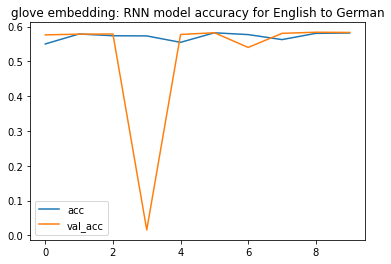

In [ ]:
plot_model_accuracy(glove_rnn_history_en,'glove embedding: RNN model accuracy for English to German')

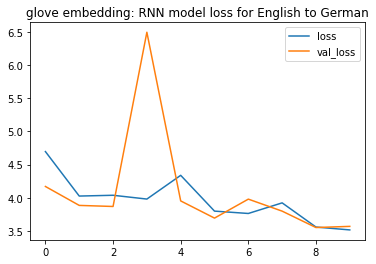

In [ ]:
plot_model_loss(glove_rnn_history_en,'glove embedding: RNN model loss for English to German')

**Input as English and translate to German for LSTM model**

In [ ]:
glove_lstm_model_en,glove_lstm_history_en = build_rnn_lstm_model_with_glove(in_num_words_en,
                                                            out_num_words_de,
                                                            glove_embedding_en,
                                                            eng_length,
                                                            deu_length,
                                                            UNIT_size,
                                                            LSTM_model,
                                                            train_en_in,
                                                            train_de_out,
                                                            EPOCH_size,
                                                            BATCH_size)

Epoch 1/10
150/150 [==============================] - 30s 171ms/step - loss: 4.1360 - acc: 0.5752 - val_loss: 3.6532 - val_acc: 0.5814
Epoch 2/10
150/150 [==============================] - 25s 168ms/step - loss: 3.5578 - acc: 0.5862 - val_loss: 3.5685 - val_acc: 0.5840
Epoch 3/10
150/150 [==============================] - 25s 166ms/step - loss: 3.4481 - acc: 0.5883 - val_loss: 3.5232 - val_acc: 0.5848
Epoch 4/10
150/150 [==============================] - 25s 166ms/step - loss: 3.3847 - acc: 0.5893 - val_loss: 3.4882 - val_acc: 0.5868
Epoch 5/10
150/150 [==============================] - 23s 154ms/step - loss: 3.3292 - acc: 0.5906 - val_loss: 3.4205 - val_acc: 0.5885
Epoch 6/10
150/150 [==============================] - 25s 167ms/step - loss: 3.2928 - acc: 0.5915 - val_loss: 3.4544 - val_acc: 0.5880
Epoch 7/10
150/150 [==============================] - 25s 167ms/step - loss: 3.2555 - acc: 0.5919 - val_loss: 3.4090 - val_acc: 0.5889
Epoch 8/10
150/150 [==============================] - 2

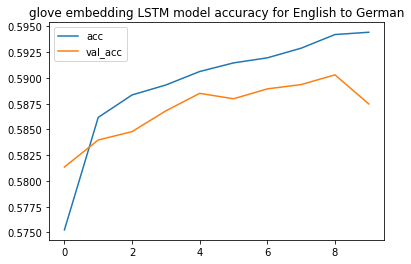

In [ ]:
plot_model_accuracy(glove_lstm_history_en,'glove embedding LSTM model accuracy for English to German')

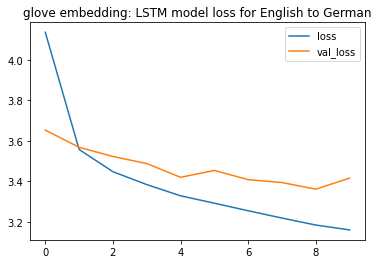

In [ ]:
plot_model_loss(glove_lstm_history_en,'glove embedding: LSTM model loss for English to German')

**Input as German and translate to English for RNN model**

In [ ]:
glove_rnn_model_de,glove_rnn_history_de = build_rnn_lstm_model_with_glove(in_num_words_de,
                                                            out_num_words_en,
                                                            glove_embedding_de,
                                                            eng_length,
                                                            deu_length,
                                                            UNIT_size,
                                                            RNN_model,
                                                            train_de_in,
                                                            train_en_out,
                                                            EPOCH_size,
                                                            BATCH_size)

Epoch 1/10
150/150 [==============================] - 29s 183ms/step - loss: 4.8275 - acc: 0.5093 - val_loss: 3.9396 - val_acc: 0.5496
Epoch 2/10
150/150 [==============================] - 27s 179ms/step - loss: 3.8755 - acc: 0.5525 - val_loss: 3.7202 - val_acc: 0.5558
Epoch 3/10
150/150 [==============================] - 26s 176ms/step - loss: 3.8695 - acc: 0.5398 - val_loss: 3.7133 - val_acc: 0.5544
Epoch 4/10
150/150 [==============================] - 29s 196ms/step - loss: 3.7111 - acc: 0.5553 - val_loss: 3.5713 - val_acc: 0.5581
Epoch 5/10
150/150 [==============================] - 27s 182ms/step - loss: 3.6851 - acc: 0.5477 - val_loss: 3.6780 - val_acc: 0.5577
Epoch 6/10
150/150 [==============================] - 27s 178ms/step - loss: 3.7863 - acc: 0.5496 - val_loss: 3.7746 - val_acc: 0.5504
Epoch 7/10
150/150 [==============================] - 27s 181ms/step - loss: 3.6203 - acc: 0.5588 - val_loss: 3.7240 - val_acc: 0.5565
Epoch 8/10
150/150 [==============================] - 2

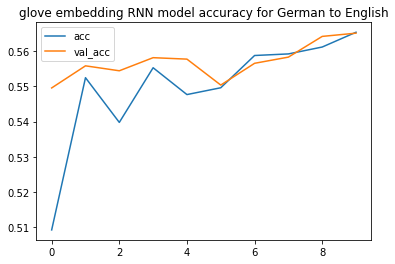

In [ ]:
plot_model_accuracy(glove_rnn_history_de,'glove embedding RNN model accuracy for German to English')

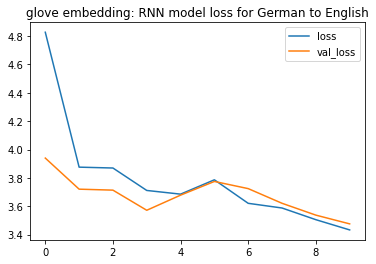

In [ ]:
plot_model_loss(glove_rnn_history_de,'glove embedding: RNN model loss for German to English')

**Input as German and translate to English for LSTM model**

In [ ]:
glove_lstm_model_de,glove_lstm_history_de = build_rnn_lstm_model_with_glove(in_num_words_de,
                                                            out_num_words_en,
                                                            glove_embedding_de,
                                                            eng_length,
                                                            deu_length,
                                                            UNIT_size,
                                                            LSTM_model,
                                                            train_de_in,
                                                            train_en_out,
                                                            EPOCH_size,
                                                            BATCH_size)

Epoch 1/10
150/150 [==============================] - 20s 114ms/step - loss: 4.0244 - acc: 0.5511 - val_loss: 3.6368 - val_acc: 0.5543
Epoch 2/10
150/150 [==============================] - 15s 102ms/step - loss: 3.5588 - acc: 0.5630 - val_loss: 3.5547 - val_acc: 0.5609
Epoch 3/10
150/150 [==============================] - 15s 102ms/step - loss: 3.4724 - acc: 0.5657 - val_loss: 3.4864 - val_acc: 0.5668
Epoch 4/10
150/150 [==============================] - 16s 105ms/step - loss: 3.4047 - acc: 0.5679 - val_loss: 3.6090 - val_acc: 0.5501
Epoch 5/10
150/150 [==============================] - 15s 102ms/step - loss: 3.3697 - acc: 0.5689 - val_loss: 3.4234 - val_acc: 0.5669
Epoch 6/10
150/150 [==============================] - 15s 101ms/step - loss: 3.3446 - acc: 0.5697 - val_loss: 3.4523 - val_acc: 0.5634
Epoch 7/10
150/150 [==============================] - 15s 102ms/step - loss: 3.3181 - acc: 0.5704 - val_loss: 3.4133 - val_acc: 0.5679
Epoch 8/10
150/150 [==============================] - 1

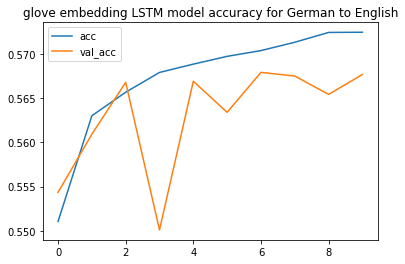

In [ ]:
plot_model_accuracy(glove_lstm_history_de,'glove embedding LSTM model accuracy for German to English')

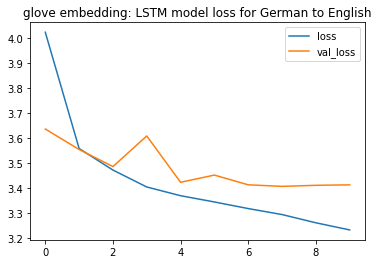

In [ ]:
plot_model_loss(glove_lstm_history_de,'glove embedding: LSTM model loss for German to English')

# **Step 2**

**Input as English and translate to German for Bi-directional RNN model**

In [ ]:
bi_rnn_model_en,bi_rnn_history_en = build_rnn_bi_lstm_model_with_glove(in_num_words_en,
                                                                     out_num_words_de,
                                                                     glove_embedding_en,
                                                                     eng_length,
                                                                     deu_length,
                                                                     UNIT_size,
                                                                     RNN_model,
                                                                     train_en_in,
                                                                     train_de_out,
                                                                     EPOCH_size,
                                                                     BATCH_size)

Epoch 1/10
150/150 [==============================] - 75s 468ms/step - loss: 4.2197 - acc: 0.5750 - val_loss: 4.0115 - val_acc: 0.5773
Epoch 2/10
150/150 [==============================] - 69s 461ms/step - loss: 4.4215 - acc: 0.5604 - val_loss: 4.0984 - val_acc: 0.5747
Epoch 3/10
150/150 [==============================] - 69s 461ms/step - loss: 3.9075 - acc: 0.5800 - val_loss: 3.9386 - val_acc: 0.5778
Epoch 4/10
150/150 [==============================] - 72s 478ms/step - loss: 3.7767 - acc: 0.5809 - val_loss: 4.0598 - val_acc: 0.5712
Epoch 5/10
150/150 [==============================] - 70s 468ms/step - loss: 3.7239 - acc: 0.5814 - val_loss: 3.7407 - val_acc: 0.5786
Epoch 6/10
150/150 [==============================] - 71s 472ms/step - loss: 3.5550 - acc: 0.5856 - val_loss: 3.5825 - val_acc: 0.5844
Epoch 7/10
150/150 [==============================] - 70s 470ms/step - loss: 3.5105 - acc: 0.5844 - val_loss: 3.6336 - val_acc: 0.5832
Epoch 8/10
150/150 [==============================] - 7

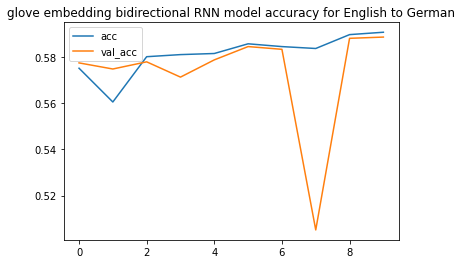

In [ ]:
plot_model_accuracy(bi_rnn_history_en,'glove embedding bidirectional RNN model accuracy for English to German')

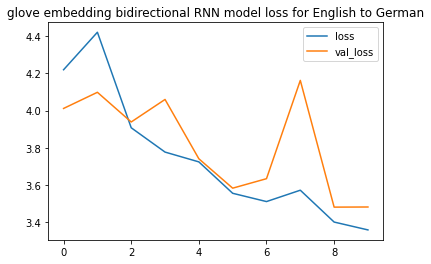

In [ ]:
plot_model_loss(bi_rnn_history_en,'glove embedding bidirectional RNN model loss for English to German')

**Input as English and translate to German for Bi-directional LSTM model**

In [ ]:
bi_lstm_model_en,bi_lstm_history_en = build_rnn_bi_lstm_model_with_glove(in_num_words_en,
                                                                     out_num_words_de,
                                                                     glove_embedding_en,
                                                                     eng_length,
                                                                     deu_length,
                                                                     UNIT_size,
                                                                     LSTM_model,
                                                                     train_en_in,
                                                                     train_de_out,
                                                                     EPOCH_size,
                                                                     BATCH_size)

Epoch 1/10
150/150 [==============================] - 51s 247ms/step - loss: 3.9514 - acc: 0.5793 - val_loss: 3.8057 - val_acc: 0.5822
Epoch 2/10
150/150 [==============================] - 35s 236ms/step - loss: 3.5479 - acc: 0.5869 - val_loss: 3.5058 - val_acc: 0.5855
Epoch 3/10
150/150 [==============================] - 35s 236ms/step - loss: 3.4255 - acc: 0.5887 - val_loss: 3.4398 - val_acc: 0.5872
Epoch 4/10
150/150 [==============================] - 37s 246ms/step - loss: 3.3358 - acc: 0.5911 - val_loss: 3.3983 - val_acc: 0.5884
Epoch 5/10
150/150 [==============================] - 37s 244ms/step - loss: 3.2767 - acc: 0.5921 - val_loss: 3.3905 - val_acc: 0.5890
Epoch 6/10
150/150 [==============================] - 37s 245ms/step - loss: 3.2313 - acc: 0.5937 - val_loss: 3.3641 - val_acc: 0.5908
Epoch 7/10
150/150 [==============================] - 36s 239ms/step - loss: 3.1876 - acc: 0.5951 - val_loss: 3.3674 - val_acc: 0.5915
Epoch 8/10
150/150 [==============================] - 3

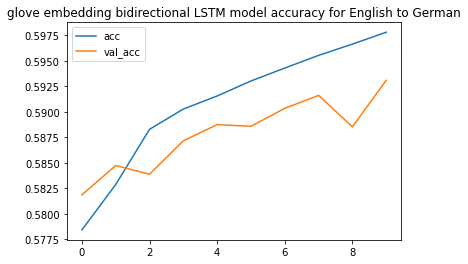

In [ ]:
plot_model_accuracy(bi_lstm_history_en,'glove embedding bidirectional LSTM model accuracy for English to German')

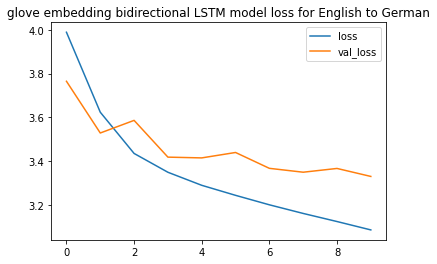

In [ ]:
plot_model_loss(bi_lstm_history_en,'glove embedding bidirectional LSTM model loss for English to German')

**Input as German and translate to English for Bi-directional RNN model**

In [ ]:
bi_rnn_model_de,bi_rnn_history_de = build_rnn_bi_lstm_model_with_glove(in_num_words_de,
                                                                     out_num_words_en,
                                                                     glove_embedding_de,
                                                                     eng_length,
                                                                     deu_length,
                                                                     UNIT_size,
                                                                     RNN_model,
                                                                     train_de_in,
                                                                     train_en_out,
                                                                     EPOCH_size,
                                                                     BATCH_size)

Epoch 1/10
150/150 [==============================] - 65s 398ms/step - loss: 4.1268 - acc: 0.5440 - val_loss: 3.9654 - val_acc: 0.5496
Epoch 2/10
150/150 [==============================] - 61s 409ms/step - loss: 3.9825 - acc: 0.5483 - val_loss: 3.7879 - val_acc: 0.5530
Epoch 3/10
150/150 [==============================] - 62s 409ms/step - loss: 3.7945 - acc: 0.5504 - val_loss: 3.7361 - val_acc: 0.5573
Epoch 4/10
150/150 [==============================] - 59s 390ms/step - loss: 3.6801 - acc: 0.5577 - val_loss: 3.5945 - val_acc: 0.5625
Epoch 5/10
150/150 [==============================] - 59s 397ms/step - loss: 3.6656 - acc: 0.5575 - val_loss: 4.0998 - val_acc: 0.5467
Epoch 6/10
150/150 [==============================] - 59s 391ms/step - loss: 3.8087 - acc: 0.5534 - val_loss: 3.6164 - val_acc: 0.5603
Epoch 7/10
150/150 [==============================] - 59s 391ms/step - loss: 3.6311 - acc: 0.5585 - val_loss: 3.5441 - val_acc: 0.5627
Epoch 8/10
150/150 [==============================] - 6

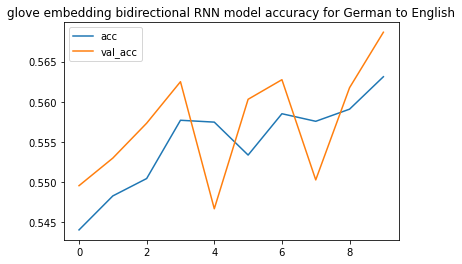

In [ ]:
plot_model_accuracy(bi_rnn_history_de,'glove embedding bidirectional RNN model accuracy for German to English')

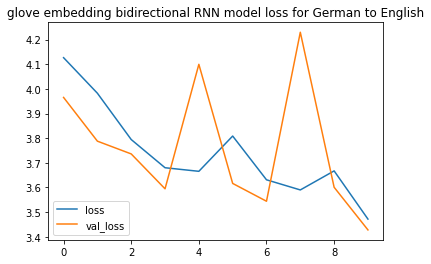

In [ ]:
plot_model_loss(bi_rnn_history_de,'glove embedding bidirectional RNN model loss for German to English')

**Input as German and translate to English for Bi-directional LSTM model**

In [ ]:
bi_lstm_model_de,bi_lstm_history_de = build_rnn_bi_lstm_model_with_glove(in_num_words_de,
                                                                     out_num_words_en,
                                                                     glove_embedding_de,
                                                                     eng_length,
                                                                     deu_length,
                                                                     UNIT_size,
                                                                     LSTM_model,
                                                                     train_de_in,
                                                                     train_en_out,
                                                                     EPOCH_size,
                                                                     BATCH_size)

Epoch 1/10
150/150 [==============================] - 37s 189ms/step - loss: 3.8908 - acc: 0.5537 - val_loss: 3.5890 - val_acc: 0.5614
Epoch 2/10
150/150 [==============================] - 27s 179ms/step - loss: 3.5064 - acc: 0.5663 - val_loss: 3.5060 - val_acc: 0.5673
Epoch 3/10
150/150 [==============================] - 27s 176ms/step - loss: 3.4717 - acc: 0.5652 - val_loss: 3.4251 - val_acc: 0.5681
Epoch 4/10
150/150 [==============================] - 27s 177ms/step - loss: 3.3619 - acc: 0.5700 - val_loss: 3.5080 - val_acc: 0.5640
Epoch 5/10
150/150 [==============================] - 27s 177ms/step - loss: 3.2877 - acc: 0.5722 - val_loss: 3.3443 - val_acc: 0.5707
Epoch 6/10
150/150 [==============================] - 27s 177ms/step - loss: 3.2268 - acc: 0.5743 - val_loss: 3.4041 - val_acc: 0.5698
Epoch 7/10
150/150 [==============================] - 27s 178ms/step - loss: 3.1735 - acc: 0.5762 - val_loss: 3.4239 - val_acc: 0.5713
Epoch 8/10
150/150 [==============================] - 2

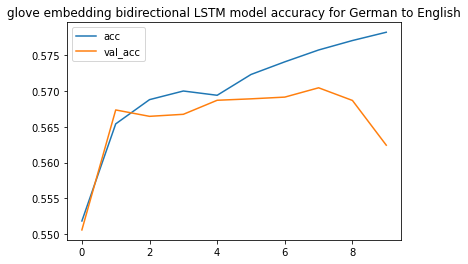

In [ ]:
plot_model_accuracy(bi_lstm_history_de,'glove embedding bidirectional LSTM model accuracy for German to English')

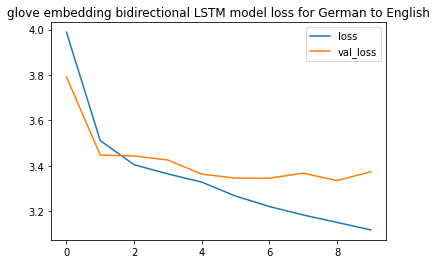

In [ ]:
plot_model_loss(bi_lstm_history_de,'glove embedding bidirectional LSTM model loss for German to English')

In [ ]:
test_en_x1 = test_en_x[:10]

In [ ]:
test_en_x1.shape

(10, 50)

In [ ]:
evaluate_model(lstm_model_en, deu_tokenizer, test_en_x1)

NameError: ignored

In [ ]:
preds = lstm_model_en.predict(test_en_x1.reshape((test_en_x1.shape[0],test_en_x1.shape[1])))

1/1 [==============================] - 0s 27ms/step


In [ ]:
preds1 = [argmax(vector) for vector in preds]

In [ ]:
preds2 = np.argmax(preds,axis=1)

In [ ]:
preds_text = []
target = list()
for i in preds2:
  word = get_word(i, deu_tokenizer)
  if word is None:
    break
  target.append(word)
' '.join(target)

ValueError: ignored

In [ ]:
target[:10]

[]

In [ ]:
test_en_x[:10]

In [ ]:
test_en_y[:10]

In [ ]:
evaluate_model(bi_lstm_model_en, deu_tokenizer, test_en_in)

2/2 [==============================] - 2s 41ms/step
predicted=[]
2/2 [==============================] - 0s 40ms/step
predicted=[]
2/2 [==============================] - 0s 40ms/step
predicted=[]
2/2 [==============================] - 0s 40ms/step
predicted=[]
2/2 [==============================] - 0s 41ms/step
predicted=[]
2/2 [==============================] - 0s 41ms/step
predicted=[]
2/2 [==============================] - 0s 44ms/step
predicted=[]
2/2 [==============================] - 0s 42ms/step
predicted=[]
2/2 [==============================] - 0s 41ms/step
predicted=[]
2/2 [==============================] - 0s 41ms/step
predicted=[]
2/2 [==============================] - 0s 39ms/step


KeyboardInterrupt: ignored

In [ ]:
en_tokenizer_pred = tokenization("please rise then for this minute s silence")
en_vocab_size_pred = len(en_tokenizer_pred.word_index) + 1
print('Size of sentences:',en_vocab_size_pred)
eng_sent = "please rise then for this minute s silence"
en_tokenizer_pad = padding_sequence(eng_tokenizer,50,eng_sent)


Size of sentences: 16


In [ ]:
en_tokenizer_pad.shape

(42, 50)

In [ ]:
#en_tokenizer_pad = en_tokenizer_pad.reshape((1, en_tokenizer_pad.shape[0]))

ger_tran = predict_sequence(bi_lstm_model_en,deu_tokenizer,en_tokenizer_pad)

2/2 [==============================] - 0s 43ms/step
prediction: [[[4.97311473e-01 9.76740494e-02 2.95152105e-02 ... 9.53057054e-07
   9.28502061e-07 9.30915519e-07]
  [7.52762377e-01 1.26993954e-02 6.30707387e-03 ... 1.42564727e-06
   1.42200838e-06 1.41122462e-06]
  [8.49056542e-01 4.24221251e-03 2.36142846e-03 ... 1.09190296e-06
   1.09066241e-06 1.08054940e-06]
  ...
  [9.98441279e-01 8.64444737e-05 5.93567456e-05 ... 1.06818343e-09
   1.05671372e-09 1.07189790e-09]
  [9.98000801e-01 1.03966930e-04 8.07311953e-05 ... 1.11509646e-09
   1.10705622e-09 1.11838516e-09]
  [9.97451603e-01 1.49974439e-04 1.28739281e-04 ... 1.02814812e-09
   1.02890918e-09 1.01275266e-09]]

 [[7.46344551e-02 3.40756290e-02 1.82957985e-02 ... 4.32592060e-06
   4.27169107e-06 4.09265385e-06]
  [8.64436179e-02 6.25123363e-03 1.16369305e-02 ... 2.75297202e-06
   2.68595454e-06 2.58210162e-06]
  [3.48634332e-01 3.03179794e-03 4.89274506e-03 ... 2.62560707e-06
   2.56084991e-06 2.49748018e-06]
  ...
  [9.99983311

In [ ]:
print(ger_tran)

**Model summary and plot for Bi-directional LSTM for English to German**

In [ ]:
bi_lstm_model_en.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 50, 200)           4644200   
                                                                 
 bidirectional_8 (Bidirectio  (None, 512)              935936    
 nal)                                                            
                                                                 
 repeat_vector_8 (RepeatVect  (None, 50, 512)          0         
 or)                                                             
                                                                 
 bidirectional_9 (Bidirectio  (None, 50, 512)          1574912   
 nal)                                                            
                                                                 
 bidirectional_10 (Bidirecti  (None, 50, 512)          1574912   
 onal)                                                

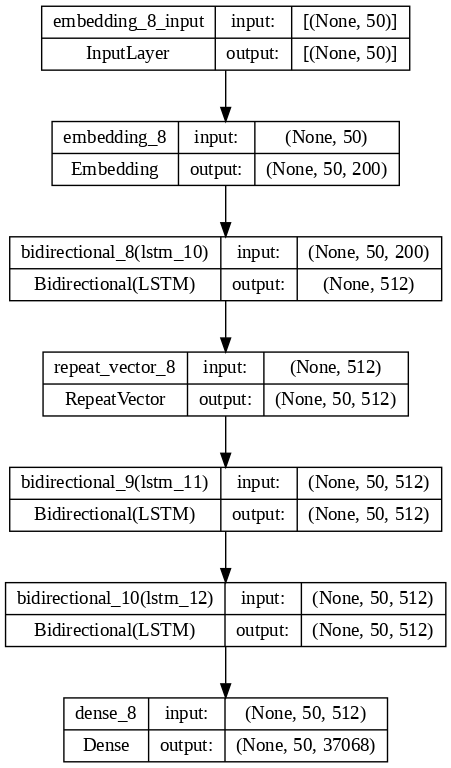

In [ ]:
plot_model(bi_lstm_model_en,'bi_lstm_history_en.png',show_shapes=True,dpi=100)

**Model summary and plot for Bi-directional LSTM for German to English**

In [ ]:
bi_lstm_model_de.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 50, 200)           7413600   
                                                                 
 bidirectional_11 (Bidirecti  (None, 512)              935936    
 onal)                                                           
                                                                 
 repeat_vector_9 (RepeatVect  (None, 50, 512)          0         
 or)                                                             
                                                                 
 bidirectional_12 (Bidirecti  (None, 50, 512)          1574912   
 onal)                                                           
                                                                 
 bidirectional_13 (Bidirecti  (None, 50, 512)          1574912   
 onal)                                                

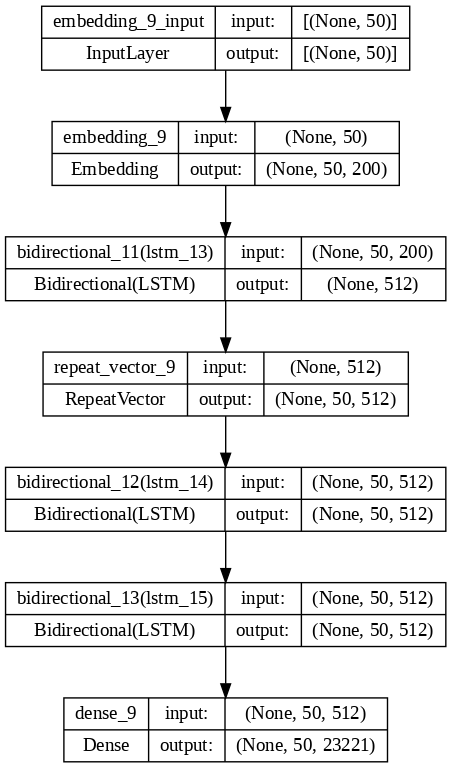

In [ ]:
plot_model(bi_lstm_model_de,'bi_lstm_history_de.png',show_shapes=True,dpi=100)